In [1]:
import string
import numpy as np
from PIL import Image
import os
from numpy import argmax
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from tqdm import tqdm_notebook as tqdm


Using TensorFlow backend.


In [2]:
def extract_features(directory):
# load the model
    model = InceptionV3()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # summarize
    print(model.summary())
    # extract features from each photo
    #features = []
    #for name in os.listdir(directory):
        # load an image from file
    filename = directory
    image = load_img(filename, target_size=(299,299))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    # get image id
    #image_id = name.split('.')[0]
    # store feature
    #features[image_id] = feature
    #print('>%s' % name)
    print(feature)
    return feature

In [3]:
letsee = str()
def load_photos(filename):
    file = open(filename,"r")
    file= file.read()
    #print(type(file))
    photos = file.split("\n")[:-1]
    return photos
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = open(filename,"r")
    file= file.read()
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open("C:\\Users\\hp\\Music\\features.p","rb"))
   # print(type(all_features))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features
filename = "C:\\Users\\hp\Music\\Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("C:\\Users\\hp\\Music\\descriptions.txt", train_imgs)
train_features = load_features(train_imgs)
len(train_descriptions)

6000

In [4]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open("C:\\Users\\hp\Music\\tokenizer.p", 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [5]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(train_descriptions)
max_length
len(train_features[train_imgs[0]][0])

2048

In [59]:
#####making changes
con = []
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
           
            
           # inputtotal= np.hstack((input_image,input_sequence))
            #inputtotal= inputtotal.reshape(inputtotal[0],inputtotal[1],1)
          #  print(len(inputtotal))
            yield [[np.array(input_image), np.array(input_sequence)], np.array(output_word)]
           # yield [inputtotal, np.array(output_word)]
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    
    #print(len(X1))
   # con= np.append(X1,X2,axis=0)
   # x1,x2=np.array(X1), np.array(X2)
    
    
    #print(np.hstack((x1,x2)).shape)
    return np.array(X1), np.array(X2), np.array(y)
#You can check the shape of the input and output for your model
#[a,b],c = next(data_generator(train_descriptions, train_features, tokenizer, max_length))
#a.shape, b.shape, c.shape


In [62]:
generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
inputs,outputs = next(generator)
#inputs,outputs = next(generator)
inputs[0].shape

#print(inputs.shape)
#print(inputs[1].shape)
#print(outputs.shape)
#print(inputs2[1].shape)
#print(outputs2.shape)
#train_descriptions['1000268201_693b08cb0e.jpg']


(47, 2048)

In [70]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    
    se3 = LSTM(512)(se2)
   # se4= LSTM(256)(se3)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(512, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    
    return model

# create changes


In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
#model = load_model("model_9.h5")
model = define_model(vocab_size, max_length)

epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
generator = data_generator(train_descriptions, train_features, tokenizer, max_length)

#print(type(generator))
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save('model_' + str(i+10) + '.h5')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  34
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 256)      1939712     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_5[0][0]      

In [31]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'start'
    # iterate over the whole length of the sequence
    for i in range(max_length):
# integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
# pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
      #  print(i)
       # i=i+1;
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'end':
            break
    return in_text


In [42]:
tokenizer = load(open("C:\\Users\\hp\Music\\tokenizer.p", 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
#model = load_model('model-ep002-loss3.245-val_loss3.612.h5')
# load and prepare the photograph
photo = extract_features("C:\\Users\\hp\\Music\\dog.jpg")
# generate description
#photo=photo.reshape(2048)
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
____________________________________________________________________________________________

[[0.48384342 0.12837179 0.06242282 ... 0.0767891  0.771006   0.38514075]]
start man in red shirt is standing in front of store end


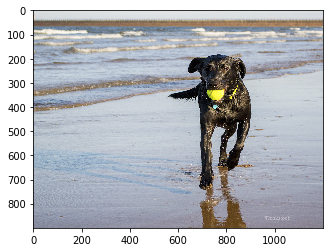

In [37]:
import matplotlib.pyplot as plt
image= plt.imread("C:\\Users\\hp\\Music\\imagedog.jpg")
plt.imshow(image)

In [45]:
img= load_img("C:\\Users\\hp\\Pictures\\photo1.jpg",target_size=(224,224))
#img.shape


In [49]:
model=VGG16()

In [51]:
#model.layers.pop()
model= Model(inputs =model.inputs,outputs=model.layers[-1].output)
print(model.summary)
#image = preprocess_input(img)
#feature= model.predict(image,verbose=0)
#feature=feature.reshape(1000)
#feature.argmax()
#for layer in model.layers:
 #   print(layer)
type(model)


<bound method Network.summary of <keras.engine.training.Model object at 0x00000294C2D28288>>


keras.engine.training.Model

In [ ]:
image= img_to_array(img)

image= image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
image= preprocess_input(image)

In [8]:
lines= ["hello i am ayush","wswf weg erg erg","wefewg ejgljmi jmglkjmg egkm jdkj jijiji kjij"]
token= Tokenizer()

token.fit_on_texts(lines)
d=token.word_index
#d["hello"]
print(d["hello"])
l= "i am hello i kjij"
m= "am hello erg"
x= []  
sequen= token.texts_to_sequences([l])[0]
sequen2= token.texts_to_sequences([m])[0]

print(type(sequen))
sequence = pad_sequences([sequen],maxlen=10)[0]
sequence2= pad_sequences([sequen2],maxlen=10)[0]
x.append(sequence)
x.append(sequence2)
print(sequence)
out_seq=sequen[0]
a=to_categorical([out_seq], num_classes=10)[0]
a
np.array(x)
sequence

2
<class 'list'>
[ 0  0  0  0  0  3  4  2  3 14]


array([ 0,  0,  0,  0,  0,  3,  4,  2,  3, 14])

In [9]:
pad_sequences?

In [11]:
###########    Not to compile model again and again ###########
###########   Simple save it and use it in future "###########

In [4]:
a=np.array([1,2,3,5,7,8,9,8,0])
b=np.array([3,4,5])
c=np.concatenate([a,b])
%pwd
model = load_model("model_9.h5")
type(model)


(12,)